In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn 

import gymnasium as gym

In [2]:
class CEM(nn.Module):
    def __init__(self, state_dim, action_n):
        super().__init__()
        self.state_dim = state_dim
        self.action_n = action_n
        
        self.network = nn.Sequential(
            nn.Linear(self.state_dim, 100), 
            nn.ReLU(), 
            nn.Linear(100, self.action_n)
        )
        
        self.softmax = nn.Softmax(dim=-1)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, _input):
        return self.network(_input) 
    
    def get_action(self, state):
        state = torch.FloatTensor(np.array(state))
        logits = self.forward(state)
        action_prob = self.softmax(logits).detach().numpy()
        action = np.random.choice(self.action_n, p=action_prob)
        return action
    
    def update_policy(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        elite_states = torch.FloatTensor(np.array(elite_states))
        elite_actions = torch.LongTensor(np.array(elite_actions))
        
        loss = self.loss(self.forward(elite_states), elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

In [3]:
def get_trajectory(env, agent, trajectory_len, visualize=False):
    trajectory = {'states':[], 'actions': [], 'total_reward': 0}
    
    state, _ = env.reset()
    trajectory['states'].append(state)
    
    for _ in range(trajectory_len):
        
        action = agent.get_action(state)
        trajectory['actions'].append(action)
        
        state, reward, done, truncate, _ = env.step(action)
        
        if done or truncate:
            break
            
        if visualize:
            env.render()
        trajectory['total_reward'] += reward
        trajectory['states'].append(state)
        
    return trajectory

In [4]:
def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param) 
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]

100%|██████████| 200/200 [01:16<00:00,  2.63it/s]


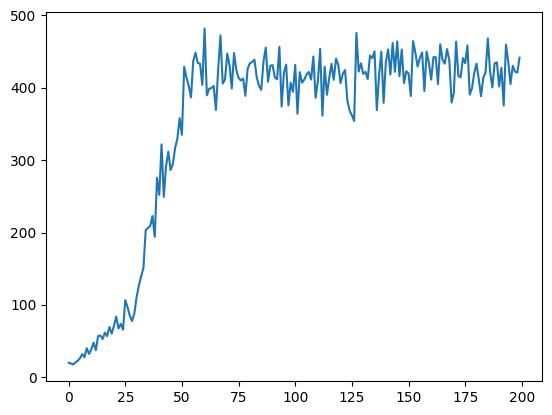

In [5]:
import matplotlib.pyplot as plt
env = gym.make('CartPole-v1')
state_dim = 4
action_n = 2

agent = CEM(state_dim, action_n)
episode_n = 200
trajectory_n = 20
trajectory_len = 500
q_param = 0.8
total_reward = []

for episode in tqdm(range(episode_n)):
    trajectories = [get_trajectory(env, agent, trajectory_len) for _ in range(trajectory_n)]
    
    mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
    total_reward.append(mean_total_reward)
    
    elite_trajectories = get_elite_trajectories(trajectories, q_param)
    
    if len(elite_trajectories) > 0:
        agent.update_policy(elite_trajectories)

plt.plot(total_reward)
plt.show()